# Importing Libraries

In [18]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import warnings
warnings.filterwarnings('ignore')

!pip install fuzzywuzzy

# importing libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
from fuzzywuzzy import fuzz

import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk import tokenize
import re
import gensim
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# reading the different lexicons and defining negative words
negative_words = ["no", "not", "not any", "none", "never", "neither", "nor", "few", "hardly", "little", "scarcely", "rarely", "seldom", "isn't", "don't", "can't", "hadn't"]

xlsx_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(xlsx_file, sheet_name = 'Positive Peace Terms')
#preprocessing the peace lexicon words 
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
peace_lexicon_list = list(dfs.English)

conflict_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(conflict_file, sheet_name = 'Conflict terms')
#preprocessing the conflict lexicon words 
dfs = dfs.dropna()
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
conflict_lexicon_list = list(dfs.English)

nonPeace_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(nonPeace_file, sheet_name = 'Resilience Terms')
#preprocessing the non peace lexicon words
dfs = dfs.dropna()
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
nonPeace_lexicon_list = list(dfs.English)

In [0]:
# preprocessing the lexicons further by removing stop words
my_stopwords = set(ENGLISH_STOP_WORDS)
for i in negative_words:
  try:
    my_stopwords.remove(i)
  except:
    continue

peace_processed = []
nonPeace_processed = []
conflict_processed = []
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in peace_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  peace_processed.append(' '.join(input_str_1))
for i in nonPeace_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  nonPeace_processed.append(' '.join(input_str_1))
for i in conflict_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  conflict_processed.append(' '.join(input_str_1))

In [0]:
bbc_file = '/content/drive/My Drive/Sustainable-Peace-Project/bbc.csv'
dfs = pd.read_csv(bbc_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
bbc_news = list(dfs.Text)
bbc_news_total = ' '.join(bbc_news)

fox_file = '/content/drive/My Drive/Sustainable-Peace-Project/fox.csv'
dfs = pd.read_csv(fox_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
fox_news = list(dfs.Text)
fox_news_total = ' '.join(fox_news)

cnn_file = '/content/drive/My Drive/Sustainable-Peace-Project/cnn.csv'
dfs = pd.read_csv(cnn_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
dfs = dfs.dropna()
cnn_news = list(dfs.Text)
cnn_news_total = ' '.join(cnn_news)

# Scraping data from Google News API

In [0]:
# scraping data from the Google News API
# this function will find BBC news articles related to coronavirus in English Language
def google_news_articles(source):
    url = ('https://newsapi.org/v2/everything?'
           'sources=' + source + '&'
           'q=coronavirus&'
           'language=en&'
           'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
    response = requests.get(url)
    #print(response.json())
    news = response.json()['articles']
    desc = []
    for i in range(len(news)):
        desc.append(news[i]['description'])
    url = []
    for i in range(len(news)):
        url.append(news[i]['url'])
    return url, desc

In [0]:
bbc_urls, bbc_desc = google_news_articles('bbc-news')
cnn_urls, cnn_desc = google_news_articles('cnn')
fox_urls, fox_desc = google_news_articles('fox-news')

In [0]:
# scraping data from bbc.com
def bbc_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.findAll('p') 
    article = article[12:27]
    news_article = ""
    for a in article:
        temp = a.get_text()
        news_article = news_article + " " + temp
    return news_article

In [0]:
bbc_articles = []
for url in bbc_urls:
    bbc_articles.append(bbc_news(url))

In [0]:
bbc_articles_text = ' '.join(bbc_articles)
len(bbc_articles_text)

35188

In [0]:
# scraping data from foxnews.com
def fox_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.findAll('p')
    article = article[3:36]
    news_article = ""
    for a in article:
        temp = a.get_text()
        news_article = news_article + " " + temp
    return news_article

In [0]:
fox_articles = []
for url in fox_urls:
    fox_articles.append(fox_news(url))
fox_articles_text = ' '.join(fox_articles)
len(fox_articles_text)

71508

In [0]:
# scraping data from cnn.com
def cnn_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.findAll('div',  {"class": "l-container"})
    print(article)
    try:
      article = article[3]
    except:
      print(url)
      return ""
    news_article = ""
    for a in article:
        temp = a.get_text()
        news_article = news_article + " " + temp
    return news_article

In [0]:
cnn_articles = []
for url in cnn_urls:
    if "video" not in url:
        cnn_articles.append(cnn_news(url))
cnn_articles_text = ' '.join(cnn_articles)
len(cnn_articles_text)

https://www.cnn.com/2020/04/25/health/running-coronavirus-wellness-trnd/index.html


40709

Text(0.5, 1.0, 'Average number of characters in an article from different sources')

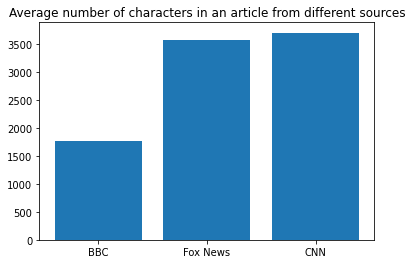

In [0]:
bbc_len = len(bbc_articles_text)/20
fox_len = len(fox_articles_text)/20
cnn_len = len(cnn_articles_text)/11

lens = [bbc_len, fox_len, cnn_len]
plt.bar(x = ['BBC', 'Fox News', 'CNN'], height=lens)
plt.title('Average number of characters in an article from different sources')

# Understanding the data

In [0]:
# preprocessing with the text

def preprocess_text(text):
    text = re.sub('[!@#$,"()'':-]', '', text.lower())
    sentences = tokenize.sent_tokenize(text)
    words = []
    temp = []
    for x in sentences:
        temp = x.split(' ')
        temp = [x for x in temp if not x in my_stopwords] # removing stop words
        temp = [x.strip('.') for x in temp] 
        temp = [x.strip('') for x in temp]
        words.append(temp)
        temp = []
    return(words)

In [0]:
# scraping top articles (first 2/3 paras) from cnn.com 
def cnn_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.find_all('article',  {"class": "sc-cJSrbW poststyles__PostBox-sc-1egoi1-0 tzojb"})
    return article



extra_cnn = cnn_news('https://www.cnn.com/us/live-news/us-coronavirus-update-04-30-20/index.html')

In [0]:
result = []
for th in extra_cnn:
    temp = th.find_all('p')
    for t in temp:
        result.append(t.get_text())

In [0]:
result_text = ' '.join(result)
len(result_text)

6926

In [0]:
cnn_news_total = cnn_news_total + result_text
len(cnn_news_total)

47634

In [0]:
bbc_words = preprocess_text(bbc_news_total)
fox_words = preprocess_text(fox_news_total)
cnn_words = preprocess_text(cnn_news_total)

In [0]:
bbc_total = [item for sublist in bbc_words for item in sublist if item != '']
bbc_counter = Counter(bbc_total)
bbc_counter.most_common(20)

[('people', 40),
 ('said', 33),
 ('not', 31),
 ('coronavirus', 29),
 ('covid19', 19),
 ('state', 17),
 ('lockdown', 16),
 ('health', 16),
 ('says', 15),
 ('world', 13),
 ('new', 13),
 ('messenger', 12),
 ('no', 11),
 ('work', 11),
 ('home', 11),
 ('just', 10),
 ('day', 10),
 ('social', 10),
 ('facebook', 10),
 ('share', 9)]

In [0]:
fox_total = [item for sublist in fox_words for item in sublist if item != '']
fox_counter = Counter(fox_total)
fox_counter.most_common(20)

[('coronavirus', 103),
 ('fox', 55),
 ('not', 52),
 ('news', 50),
 ('covid19', 49),
 ('subscribed', 38),
 ('study', 34),
 ('patients', 34),
 ('said', 33),
 ('world', 30),
 ('new', 30),
 ('published', 29),
 ('space', 29),
 ('broadcast', 28),
 ('u.s', 27),
 ('data', 24),
 ('20', 24),
 ('people', 23),
 ('pandemic', 22),
 ('virus', 22)]

In [0]:
cnn_total = [item for sublist in cnn_words for item in sublist if item != '']
cnn_counter = Counter(cnn_total)
cnn_counter.most_common(20)

[('=', 48),
 ('said', 44),
 ('cnn', 32),
 ('not', 32),
 ('police', 31),
 ('coronavirus', 29),
 ('people', 29),
 ('public', 25),
 ('enforcement', 24),
 ('law', 22),
 ('health', 20),
 ('help', 18),
 ('community', 17),
 ('states', 17),
 ('pandemic', 16),
 ('says', 16),
 ('want', 16),
 ('id', 16),
 ('los', 15),
 ('angeles', 15)]

BBC NEWS


([], <a list of 0 Text major ticklabel objects>)

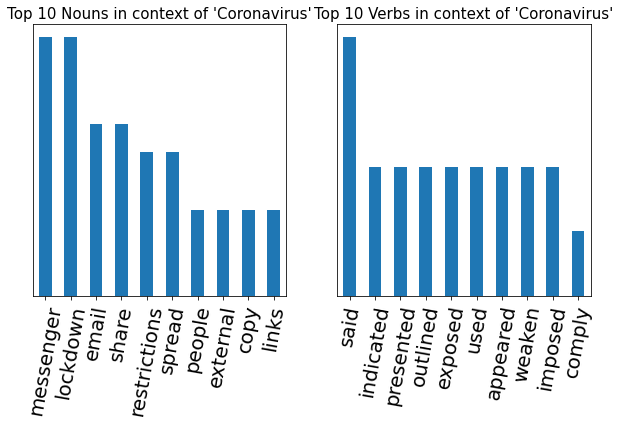

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of BBC news
from nltk.corpus import wordnet as wn
texts = []
for i in bbc_words:
  for j in i:
    if j == 'coronavirus':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)
print('BBC NEWS')
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Nouns in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Verbs in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])

FOX NEWS


([], <a list of 0 Text major ticklabel objects>)

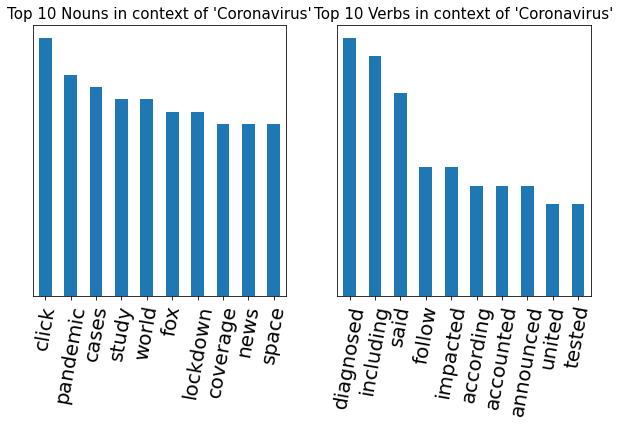

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of fox news
from nltk.corpus import wordnet as wn
texts = []
for i in fox_words:
  for j in i:
    if j == 'coronavirus':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)
print('FOX NEWS')
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Nouns in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Verbs in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])

CNN NEWS


([], <a list of 0 Text major ticklabel objects>)

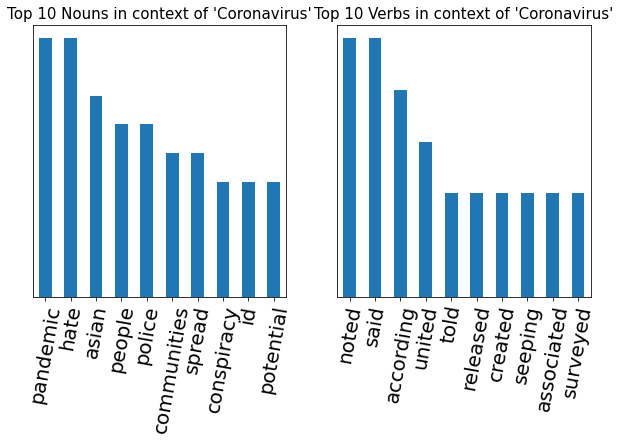

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of CNN news
from nltk.corpus import wordnet as wn
texts = []
for i in cnn_words:
  for j in i:
    if j == 'coronavirus':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)
print('CNN NEWS')
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Nouns in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Verbs in context of 'Coronavirus'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])

FOX NEWS


([], <a list of 0 Text major ticklabel objects>)

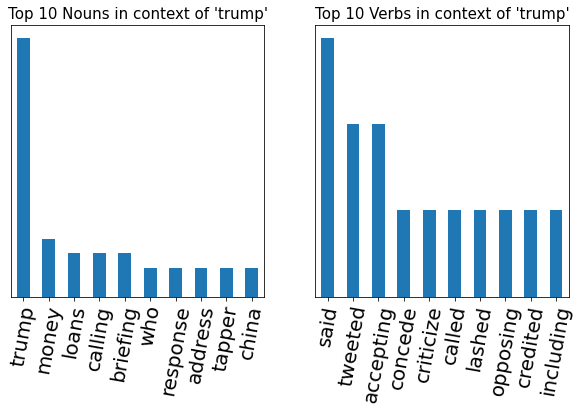

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of BBC news
from nltk.corpus import wordnet as wn
texts = []
for i in fox_words:
  for j in i:
    if j == 'trump':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)
print('FOX NEWS')
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Nouns in context of 'trump'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Verbs in context of 'trump'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])

CNN NEWS


([], <a list of 0 Text major ticklabel objects>)

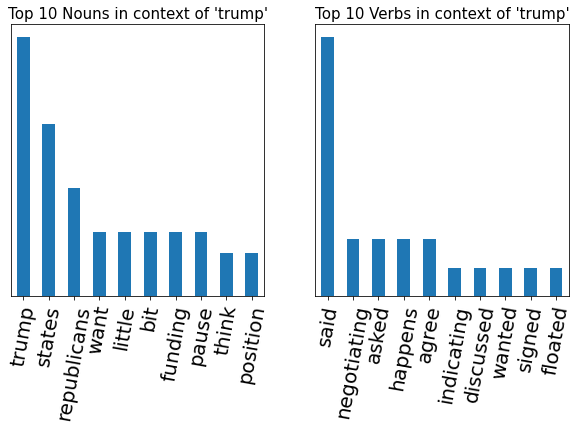

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of BBC news
from nltk.corpus import wordnet as wn
texts = []
for i in cnn_words:
  for j in i:
    if j == 'trump':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)
print('CNN NEWS')
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Nouns in context of 'trump'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(10,5))
plt.title("Top 10 Verbs in context of 'trump'",fontsize=15)
plt.xticks(size=20,rotation=80)
plt.yticks([])

# Our lexicon on the text collected above

In [0]:
# downloading the Google pretrained model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

--2020-05-01 02:12:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.4MB/s    in 45s     

2020-05-01 02:13:29 (34.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



## Functions

In [0]:
# functions for finding the peace / non-peace / conflict scores - 
def peace_score(words, lexicon):
    peace_list = []
    t = []
    score = 0
    flag = 0
    for x in words:
        for y in x:
            temp = compare_terms(y, lexicon)
            if y in negative_words and flag == 0:
                # print(y)
                flag = 1
            elif temp != None and flag == 0:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score + 1
            elif temp != None and flag == 1:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score - 1
                flag = 0
        flag = 0
    return peace_list, score

def conflict_score(words, lexicon):
    score = 0
    conflict_list = []
    t = []
    for word in words:
      for y in word:
        temp = compare_terms(y, lexicon)
        if temp != None:
          t.append(y)
          t.append(temp)
          conflict_list.append(t)
          t = []
          score = score + 1
    return conflict_list, score

def nonPeace_score(words, lexicon):
    score = 0
    nonPeace_list = []
    t = []
    for word in words:
      for y in word:
        temp = compare_terms(y, lexicon)
        if temp!=None:
          t.append(y)
          t.append(temp)
          nonPeace_list.append(t)
          t = []
          score = score + 1
    return nonPeace_list, score

# function to compare terms
def compare_terms(term, lexicon):
    for i in lexicon:
      term = term.strip(' ')
      term = term.strip('.')
      # term = term.strip('\'s')
      try:
        if term != '' and fuzz.ratio(term, i) > 85 and model.similarity(term, i) > 0.5:
          return i
      except:
        continue

In [0]:
# find the total number of words in each article
word_count = [0,0,0]
for i in bbc_words:
  word_count[0] = word_count[0] + len(i)
for i in fox_words:
  word_count[1] = word_count[1] + len(i)
for i in cnn_words:
  word_count[2] = word_count[2] + len(i)
word_count

[3104, 6589, 4236]

## Peace Terms

In [0]:
bbcterms, bbcscore = peace_score(bbc_words, peace_processed)
print(bbcscore)

foxterms, foxscore = peace_score(fox_words, peace_processed)
print(foxscore)

cnnterms, cnnscore = peace_score(cnn_words, peace_processed)
print(cnnscore)

63
138
95


In [0]:
cterms1 = [x[1] for x in bbcterms]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,help,9
1,photography,7
2,media,6
3,solidarity,4
4,agree,4
5,happening,3
6,community,3
7,positive,3
8,union,3
9,love,2


In [0]:
cterms1 = [x[1] for x in foxterms]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,science,21
1,rights,19
2,positive,18
3,unite,9
4,novels,9
5,help,6
6,understanding,5
7,accepting,5
8,commonwealth,4
9,media,4


In [0]:
cterms1 = [x[1] for x in cnnterms]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,help,18
1,community,17
2,unite,9
3,constitutional,8
4,agree,5
5,love,5
6,protection,4
7,local,4
8,growth,4
9,art,4


## Resilience Terms

In [0]:
bbcterms1, bbcscore1 = nonPeace_score(bbc_words, nonPeace_processed)
print(bbcscore1)

foxterms1, foxscore1 = nonPeace_score(fox_words, nonPeace_processed)
print(foxscore1)

cnnterms1, cnnscore1 = nonPeace_score(cnn_words, nonPeace_processed)
print(cnnscore1)

27
32
57


In [0]:
cterms1 = [x[1] for x in bbcterms1]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,service,4
1,recovery,4
2,order,3
3,capacity,3
4,union,3
5,courts,3
6,individuals,1
7,freedom,1
8,security,1
9,compliance,1


In [0]:
cterms1 = [x[1] for x in foxterms1]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,money,5
1,administration,4
2,order,4
3,service,3
4,refugee,3
5,federal,2
6,recovery,2
7,individuals,2
8,sovereignty,1
9,security,1


In [0]:
cterms1 = [x[1] for x in cnnterms1]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,order,23
1,individuals,4
2,federal,3
3,freedom,3
4,security,3
5,union,3
6,money,2
7,compliance,2
8,courts,2
9,administration,2


## Conflict Terms

In [0]:
bbcterms2, bbcscore2 = conflict_score(bbc_words, conflict_processed)
print(bbcscore2)

foxterms2, foxscore2 = conflict_score(fox_words, conflict_processed)
print(foxscore2)

cnnterms2, cnnscore2 = conflict_score(cnn_words, conflict_processed)
print(cnnscore2)

6
13
13


In [0]:
cterms1 = [x[1] for x in bbcterms2]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,crisis,4
1,fighting,1
2,war,1


In [0]:
cterms1 = [x[1] for x in foxterms2]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,war,6
1,crisis,6
2,fighting,1


In [0]:
cterms1 = [x[1] for x in cnnterms2]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,crisis,9
1,conflict,1
2,destruction,1
3,pain,1
4,fighting,1


In [0]:
peace = [bbcscore/word_count[0], foxscore/word_count[1], cnnscore/word_count[2]]
res = [bbcscore1/word_count[0], foxscore1/word_count[1], cnnscore1/word_count[2]]
conflict = [bbcscore2/word_count[0], foxscore2/word_count[1], cnnscore2/word_count[2]]

In [0]:
sources = ['BBC', 'Fox', 'CNN']
peace = [0.02029639175257732, 0.020943997571710428, 0.02242681775259679]
res = [0.008698453608247423, 0.0048565791470632875, 0.013456090651558074]
conflict = [0.0019329896907216496, 0.0019729852784944606, 0.003068932955618508]

<BarContainer object of 3 artists>

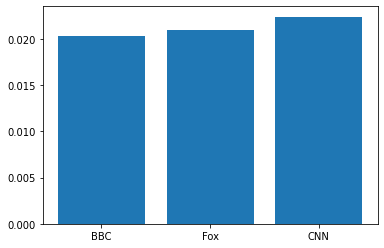

In [0]:
plt.bar(x = sources, height = peace)
plt.title('Peace Scores')

Text(0.5, 1.0, 'Non Peace Scores')

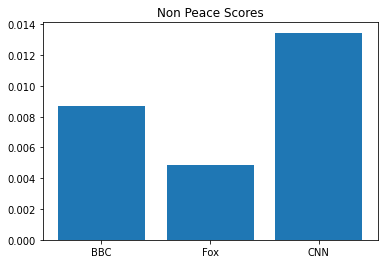

In [0]:
plt.bar(x = sources, height = res)
plt.title('Non Peace Scores')

Text(0.5, 1.0, 'Conflict Scores')

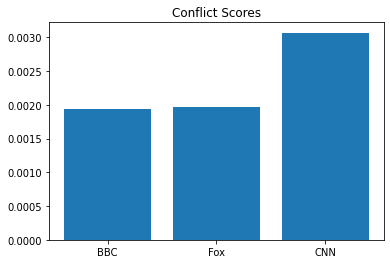

In [0]:
plt.bar(x = sources, height = conflict)
plt.title('Conflict Scores')

In [0]:
peace

[0.02029639175257732, 0.020943997571710428, 0.02242681775259679]

In [0]:
res

[0.008698453608247423, 0.0048565791470632875, 0.013456090651558074]

In [0]:
conflict

[0.0019329896907216496, 0.0019729852784944606, 0.003068932955618508]

# Saving the text files

In [0]:
pd.DataFrame(bbc_articles).to_csv('bbc.csv')
!cp bbc.csv "/content/drive/My Drive/Sustainable-Peace-Project/"

In [0]:
pd.DataFrame(fox_articles).to_csv('fox.csv')
!cp fox.csv "/content/drive/My Drive/Sustainable-Peace-Project/"

In [0]:
pd.DataFrame(cnn_articles).to_csv('cnn.csv')
!cp cnn.csv "/content/drive/My Drive/Sustainable-Peace-Project/"

# COVID News Reporting through different countries

In [0]:
# scraping data from the Google News API
# this function will find BBC news articles related to coronavirus in English Language
def google_news_articles_countries(c):
    url = ('https://newsapi.org/v2/top-headlines?'
           'country=' + c + '&'
           'q=coronavirus&'
           'language=en&'
           'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
    response = requests.get(url)
    # print(response.json())
    news = response.json()['articles']
    desc = []
    for i in range(len(news)):
        desc.append(news[i]['description'])
    url = []
    for i in range(len(news)):
        url.append(news[i]['url'])
    return url, desc

In [0]:
urls = []
desc = []
countries = ['in', 'us', 'ca', 'it', 'se', 'gb', 'cn', 've', 'nz']
for i in range(len(countries)):
    u, d = google_news_articles_countries(countries[i])
    urls.append(u)
    desc.append(d)

In [0]:
# lets compare news from US/Italy/London
desc_text = {}
desc_text['us'] = ' '.join(desc[1])
desc_text['it'] = ' '.join(desc[3])
desc_text['gb'] = ' '.join(desc[5])

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(ngram_range=(1, 3), stop_words='english')
# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform([desc_text['us']])
# needs to happen after fit_transform()
vocab = c_vec.vocabulary_
count_values = ngrams.toarray().sum(axis=0)
# output n-grams
print('Top words from news descriptions of USA')
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
  if ng_count > 1:
    print(ng_count, ng_text)

Top words from news descriptions of USA
5 coronavirus
2 university
2 trump
2 state
2 said
2 people
2 newsom
2 infected
2 important
2 covid 19
2 covid
2 19


In [0]:
!pip install googletrans

In [0]:
!pip install stop-words

In [0]:
from googletrans import Translator
translator = Translator()

In [0]:
from stop_words import get_stop_words
it_stop_words = get_stop_words('it')

c_vec = CountVectorizer(ngram_range=(1, 3), stop_words=it_stop_words)
# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform([desc_text['it']])
# needs to happen after fit_transform()
vocab = c_vec.vocabulary_
count_values = ngrams.toarray().sum(axis=0)
# output n-grams
print('Top words from news descriptions of Italy')
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
  if ng_count > 1:
    print(ng_count, translator.translate(ng_text).text)

Top words from news descriptions of Italy
3 region
3 data
3 coronavirus
3 antibodies
2 virus
2 blood
2 origin
2 dead
2 after
2 White House
2 House
2 bianca


In [0]:
from stop_words import get_stop_words
en_stop_words = get_stop_words('en')

c_vec = CountVectorizer(ngram_range=(1, 3), stop_words=en_stop_words)
# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform([desc_text['gb']])
# needs to happen after fit_transform()
vocab = c_vec.vocabulary_
count_values = ngrams.toarray().sum(axis=0)
# output n-grams
print('Top words from news descriptions of UK')
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
  if ng_count > 1:
    print(ng_count, ng_text)

Top words from news descriptions of UK
3 uk
3 mps
3 coronavirus
2 deaths
2 china
2 10


# Trying a new local news api

In [2]:
!pip install eventregistry

In [0]:
import eventregistry

In [0]:
API_KEY = 'c0e88e2f-b44a-4417-b034-5a531f544661'

In [5]:
from eventregistry import *
er = EventRegistry(apiKey = API_KEY)
q = QueryArticlesIter(conceptUri = er.getConceptUri("coronavirus"))
covidNews = []
k = 0
for art in q.execQuery(er, sortBy = "date"):
  if k==20000:
    break
  else:
    covidNews.append(art)
    k = k + 1

using user provided API key for making requests
Event Registry host: http://eventregistry.org
Text analytics host: http://analytics.eventregistry.org


In [6]:
len(covidNews)

20000

In [0]:
news_sources = []
for i in covidNews:
  news_sources.append(i['source']['title'])

In [0]:
import pandas as pd

covidNewsDf = pd.DataFrame(covidNews)
covidNewsDf.head()

In [0]:
covidNewsDf.to_csv('covidLocalNews.csv')
!cp covidLocalNews.csv "/content/drive/My Drive/Sustainable-Peace-Project/"

In [0]:
news_sources_u = set(news_sources)

In [22]:
covidNews[0]

{'authors': [{'isAgency': False,
   'name': 'Guillermo Peris Peris',
   'type': 'author',
   'uri': 'guillermo_peris_peris@diariosigloxxi.com'}],
 'body': "La quinta temporada del proyecto de creación cultural digital más relevante del sur de Europa, Círculo Fusión, reunirá próximamente, los rostros más destacados del mundo del arte, la gastronomía y la música, vinculados a la innovación y vanguardia internacional. Actualmente, debido a la crisis del coronavirus, todos los contenidos son de acceso gratuito y se está realizando una recogida de firmas, en la plataforma change.org, en apoyo a la creación cultural independiente. La gastronomía, el arte y la música, son los sectores más afectados por la grave crísis internacional del COVID-19, aún así, Círculo Fusión lanzará durante el 2020 su nueva temporada, la más internacional de todas.\n\nEl pistoletazo de salida, lo encabeza Gabriel Kreuther, con dos estrellas Michelin en su restaurante propio, fue el responsable de lanzar al estrella